# Intel Image classification

## 구글 colab 이용

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


### 디렉토리 변경

In [2]:
cd gdrive/My Drive/intel

/content/gdrive/My Drive/intel


## 패키지 불러오기

In [0]:
import os
import cv2
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline
from tensorflow.keras import optimizers
import tensorflow.keras.metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense
from tensorflow.keras import models, layers

### 클래스 네이밍

In [0]:
class_names = ['mountain', 'street', 'glacier', 'buildings', 'sea', 'forest']

class_names_label = {class_name:i for i, class_name in enumerate(class_names)}

nb_classes = len(class_names)
#nb_classes = 6

IMAGE_SIZE = (150, 150)

### 디렉토리 내부의 이미지 불러오기

In [0]:
def load_data():
    datasets = ['/content/gdrive/My Drive/intel/seg_train', '/content/gdrive/My Drive/intel/seg_test']
    output = []
    
    # Iterate through training and test sets
    for dataset in datasets:
        
        images = []
        labels = []
        
        print("Loading {}".format(dataset))
        
        # Iterate through each folder corresponding to a category
        for folder in os.listdir(dataset):
            curr_label = class_names_label[folder]
            
            # Iterate through each image in our folder
            for file in os.listdir(os.path.join(dataset, folder)):
                
                # Get the path name of the image
                img_path = os.path.join(os.path.join(dataset, folder), file)
                
                # Open and resize the img
                curr_img = cv2.imread(img_path)
                curr_img = cv2.resize(curr_img, IMAGE_SIZE) 
                
                # Append the image and its corresponding label to the output
                images.append(curr_img)
                labels.append(curr_label)
                
        images = np.array(images, dtype = 'float32')
        labels = np.array(labels, dtype = 'int32')   
        
        output.append((images, labels))

    return output

In [6]:
(train_images, train_labels), (test_images, test_labels) = load_data()

Loading /content/gdrive/My Drive/intel/seg_train
Loading /content/gdrive/My Drive/intel/seg_test


In [0]:
train_images, train_labels = shuffle(train_images, train_labels)

In [8]:
print ("Number of training examples: " + str(train_labels.shape[0]))
print ("Number of testing examples: " + str(test_labels.shape[0]))
print ("Each image is of size: " + str(train_images.shape[1:]))

Number of training examples: 14035
Number of testing examples: 3000
Each image is of size: (150, 150, 3)


## 이미지 클래스 분포 비율 확인

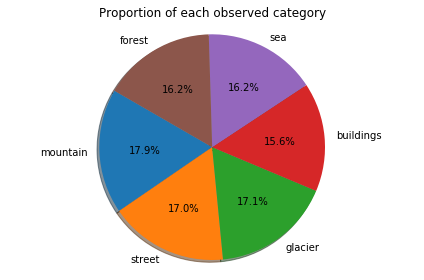

In [9]:
# Plot a pie chart
sizes = np.bincount(train_labels)
explode = (0, 0, 0, 0, 0, 0)  
plt.pie(sizes, explode=explode, labels=class_names,
autopct='%1.1f%%', shadow=True, startangle=150)
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.tight_layout()
plt.show()

### 픽셀 값 정규화하기

In [0]:
train_images = train_images / 255.0 
test_images = test_images / 255.0

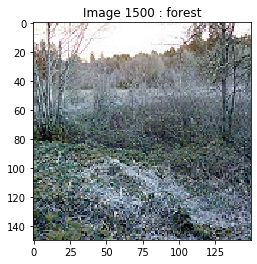

In [11]:
plt.imshow(train_images[1500])
plt.title('Image 1500 : ' + class_names[train_labels[1500]])
plt.show()

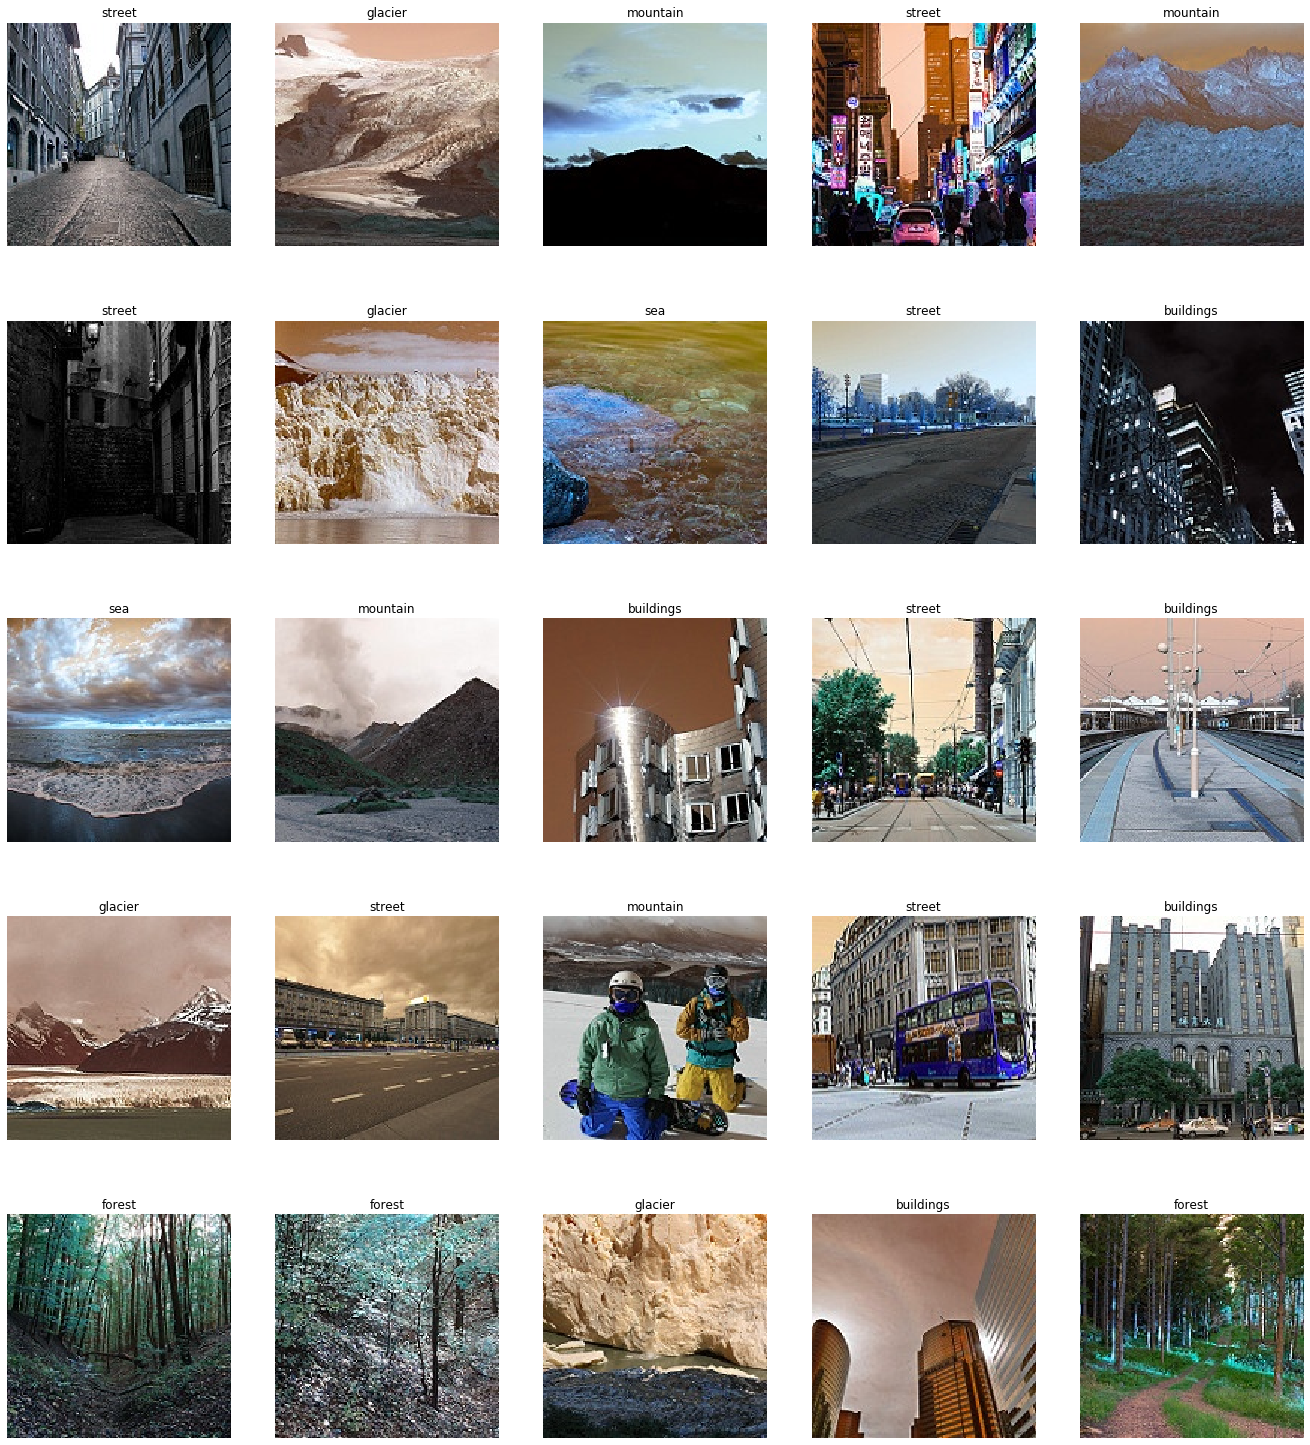

In [12]:
f,ax = plt.subplots(5,5)

f.subplots_adjust(0,0,3,5)
for i in range(0,5,1) :
    for j in range(0,5,1) :
        rnd_number = np.random.randint(0,len(train_images))
        ax[i,j].imshow(train_images[rnd_number])
        ax[i,j].set_title(class_names[train_labels[rnd_number]])
        ax[i,j].axis('off')

## 모델링

In [35]:
model = models.Sequential()

model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu',input_shape=(150,150,3)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(3,3))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.Conv2D(63,kernel_size=(3,3),activation='relu'))
#model.add(Conv2D(50,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(3,3))
model.add(layers.Flatten())
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(16,activation='relu'))
#model.add(layers.Dense(50,activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(6,activation='softmax'))

model.compile(optimizer=optimizers.Adam(lr=0.0001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 146, 146, 64)      36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 44, 44, 64)        36928     
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 42, 42, 63)        36351     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 63)       

In [36]:
history = model.fit(train_images, train_labels, epochs = 50, validation_split =  .2, callbacks = [EarlyStopping(monitor = 'val_acc', patience = 7)], verbose = 1)

Train on 11228 samples, validate on 2807 samples
Epoch 1/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 1.5252 - acc: 0.3555 - val_loss: 1.1528 - val_acc: 0.5903
Epoch 2/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 1.2726 - acc: 0.4835 - val_loss: 1.0220 - val_acc: 0.6437
Epoch 3/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 1.1911 - acc: 0.5137 - val_loss: 0.9439 - val_acc: 0.6769
Epoch 4/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 1.1032 - acc: 0.5605 - val_loss: 0.8860 - val_acc: 0.6819
Epoch 5/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 1.0461 - acc: 0.5796 - val_loss: 0.7960 - val_acc: 0.7200
Epoch 6/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 0.9902 - acc: 0.6058 - val_loss: 0.8107 - val_acc: 0.7129
Epoch 7/50
11228/11228 [==============================] - 38s 3ms/sample - loss: 0.9293 - acc: 0.6446 - val_loss: 0.6

## 학습과정에 따른 acc 및 loss 시각화

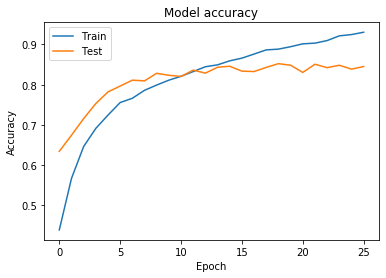

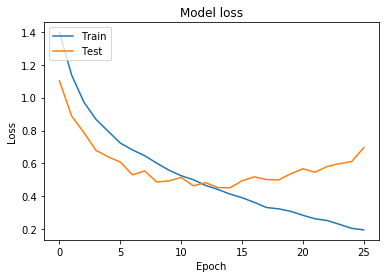

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 테스트 셋에서의 정확도

In [16]:
model.evaluate(test_images, test_labels, verbose = 1)

3000/3000 [==============================] - 8s 3ms/sample - loss: 0.6592 - acc: 0.8407


[0.6592457284523019, 0.84066665]

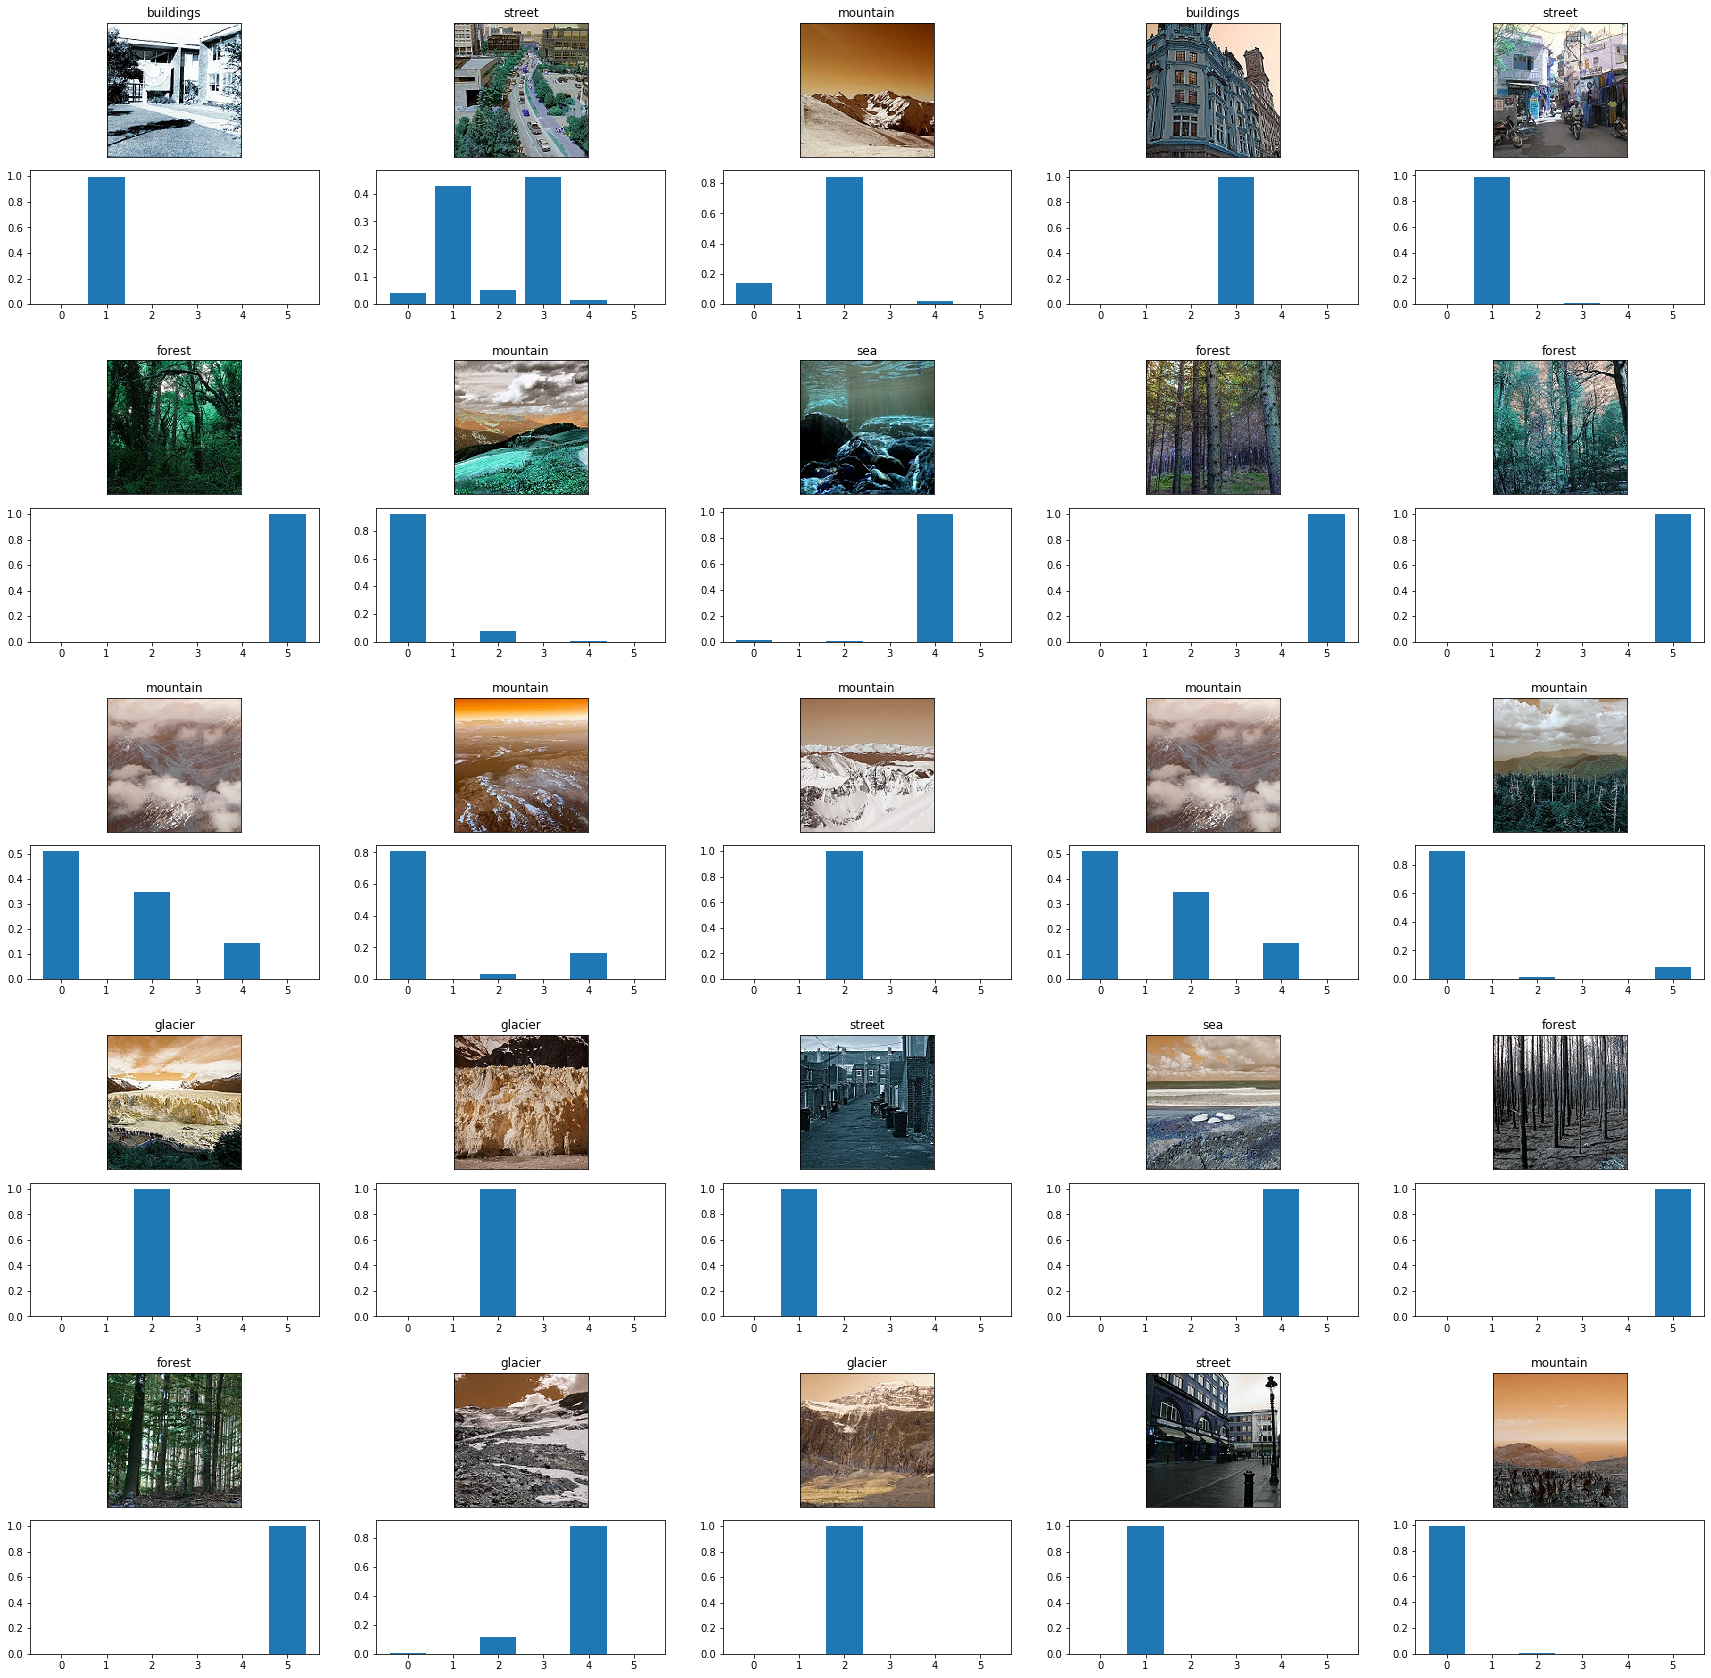

In [23]:
fig = plt.figure(figsize=(30, 30))
outer = gridspec.GridSpec(5, 5, wspace=0.2, hspace=0.2)

for i in range(25):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1,subplot_spec=outer[i], wspace=0.1, hspace=0.1)
    rnd_number = np.random.randint(0,len(test_images))
    pred_image = np.array([test_images[rnd_number]])
    pred_class = class_names[test_labels[rnd_number]]#get_classlabel(model.predict_classes(pred_image)[0])
    pred_prob = model.predict(pred_image).reshape(6)
    for j in range(2):
        if (j%2) == 0:
            ax = plt.Subplot(fig, inner[j])
            ax.imshow(pred_image[0])
            ax.set_title(pred_class)
            ax.set_xticks([])
            ax.set_yticks([])
            fig.add_subplot(ax)
        else:
            ax = plt.Subplot(fig, inner[j])
            ax.bar([0,1,2,3,4,5],pred_prob)
            fig.add_subplot(ax)


fig.show()

## Confusion Matrix 확인

In [0]:
pred = model.predict(test_images)
pred_label = np.argmax(pred, axis = 1)

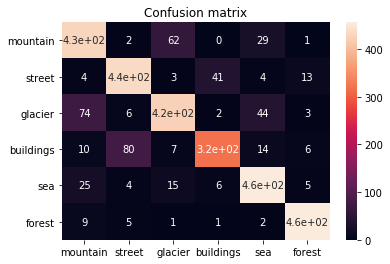

In [32]:
c_m = confusion_matrix(test_labels, pred_label)
ax = plt.axes()
sns.heatmap(c_m, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

## 사전 훈련된 모델 사용하여 정확도 향상(VGG16)

In [37]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

model = VGG16(weights='imagenet', include_top=False)





58892288/58889256 [==============================] - 2s 0us/step








In [0]:
train_features = model.predict(train_images)
test_features = model.predict(test_images)

In [44]:
train_features.shape

(14035, 4, 4, 512)

In [0]:
model2 = Sequential()
model2.add(Flatten(input_shape = (4,4,512)))
model2.add(Dense(50, activation='relu'))
model2.add(Dense(6, activation = 'softmax'))

In [48]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                409650    
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 306       
Total params: 409,956
Trainable params: 409,956
Non-trainable params: 0
_________________________________________________________________


In [0]:
model2.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

In [47]:
mhistory2 = model2.fit(train_features, train_labels, batch_size = 64, epochs = 30, validation_split = .2, callbacks =  [EarlyStopping(monitor = 'val_acc', patience = 7)], verbose = 1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 11228 samples, validate on 2807 samples
Epoch 1/30
11228/11228 [==============================] - 1s 112us/step - loss: 0.4658 - acc: 0.8304 - val_loss: 0.3228 - val_acc: 0.8874
Epoch 2/30
11228/11228 [==============================] - 1s 76us/step - loss: 0.2680 - acc: 0.9039 - val_loss: 0.3203 - val_acc: 0.8885
Epoch 3/30
11228/11228 [==============================] - 1s 74us/step - loss: 0.2206 - acc: 0.9178 - val_loss: 0.3173 - val_acc: 0.8867
Epoch 4/30
11228/11228 [==============================] - 1s 73us/step - loss: 0.1760 - acc: 0.9369 - val_loss: 0.3291 - val_acc: 0.8846
Epoch 5/30
11228/11228 [==============================] - 1s 75us/step - loss: 0.1451 - acc: 0.9499 - val_loss: 0.3274 - val_acc: 0.8921
Epoch 6/30
11228/11228 [==============================] - 1s 74us/step - loss: 0.1152 - acc: 0.9629 - val_loss: 0.3344 - val_acc: 0.8910
Epoch 7/30
11228/11228 [========

### 평가용 셋으로 모델 평가

In [49]:
model2.evaluate(test_features, test_labels)

3000/3000 [==============================] - 0s 60us/step


[0.4525842246568451, 0.8736666668256123]

## Confusion Matrix

In [0]:
pred2 = model2.predict(test_features)
pred_label2 = np.argmax(pred2, axis = 1)

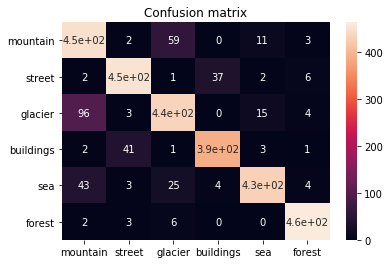

In [53]:
c_m = confusion_matrix(test_labels, pred_label2)
ax = plt.axes()
sns.heatmap(c_m, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

In [55]:
from sklearn.metrics import accuracy_score
predictions = model2.predict(test_features)    
pred_labels = np.argmax(predictions, axis = 1)
print("Accuracy : {}".format(accuracy_score(test_labels, pred_labels)))

Accuracy : 0.8736666666666667


# Finished!